##### This notebook creates STDNN-SE (pytorch) for classification prediction on Tox21

Using split data already saved.

Notebook shows results for seed = 124, but we also ran on seed 122, 123. 

Before use define desired pathways to save models,:
- path variable, in "Create checkpoint" section for models
- writer variable, in "Train the neural network model" section for tensorboard summary

In [312]:
# general and data handling
import numpy as np
import pandas as pd
import os
from collections import Counter

# Required RDKit modules
import rdkit as rd
from rdkit import DataStructs
from rdkit.Chem import AllChem

# modeling
import sklearn as sk
from sklearn.model_selection import train_test_split

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

In [313]:
import time
import random
import joblib

In [314]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [315]:
import torch
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print(device)

cpu


In [316]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [317]:
# Ensure runs on GPU
import tensorflow as tf
import datetime, os

##### Settings

In [318]:
# set seed value
seed_value = 124 #122 123 124, as used in MoleculeNet
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

In [319]:
# number of bits for morgan fingerprints
morgan_bits = 4096

In [320]:
# number of radius for morgan fingerprints
morgan_radius = 2

In [321]:
train_epoch = 50 

In [322]:
batch = 512 

##### Load raw data

In [323]:
tox21_file  = '../../../../data/datasets/tox21/raw_data/tox21.csv'
tox21_tasks = ['NR-AR', 'NR-Aromatase', 'NR-PPAR-gamma', 'SR-HSE', 
               'NR-AR-LBD', 'NR-ER', 'SR-ARE', 'SR-MMP',
               'NR-AhR', 'NR-ER-LBD', 'SR-ATAD5', 'SR-p53']

tox21_data = pd.read_csv(tox21_file)
print('Reading {}... {} data loaded.'.format(tox21_file, len(tox21_data)))
tox21_data.head()

Reading ../../../../data/datasets/tox21/raw_data/tox21.csv... 8014 data loaded.


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


#####  Setting all tasks 

In [324]:
data = [tox21_data] 

In [325]:
all_tasks = tox21_tasks 

##### Load split data

In [326]:
# load saved tox21 train/test/valid data 
data_path = "../../../../data/datasets/tox21/split_data/seed_124/"
train_data=torch.load(data_path + 'train_data_tox21.pth')
test_data=torch.load(data_path + 'test_data_tox21.pth')
valid_data=torch.load(data_path + 'valid_data_tox21.pth')

data = [train_data, test_data, valid_data]

In [327]:
print("Total number of examples, train: " + str(data[0].shape[0]))
print("Total number of examples, test: " + str(data[1].shape[0]))
print("Total number of examples, valid: " + str(data[2].shape[0]))
print("Total number of examples, train+test+valid: " + str(data[0].shape[0] + data[1].shape[0] + data[2].shape[0]))

Total number of examples, train: 6411
Total number of examples, test: 801
Total number of examples, valid: 802
Total number of examples, train+test+valid: 8014


##### SMILES embedding featurization 

In [328]:
# Load existing SE featurization - dictionary of SMILES embedding given a SMILES
smiles_embed = torch.load("../../../../data/smiles_embedding/toxicity_smiles.pt")

In [329]:
# Obtain SMILES Embedding for given SMILES 
for i in range(len(data)):
    data[i]['smiles_embed'] = data[i]['smiles'].apply(lambda x: smiles_embed.get(x))

In [330]:
# Check if any NA 
sum = 0 
for i in range(len(data)):
    na = data[i]['smiles_embed'].isna().sum()
    sum = sum + na
print(sum)

0


##### Create train, test, valid sets

In [331]:
# replace NA with -1 -- used to deal with missing labels, 
#                       along with Binary Cross-Entropy loss
data[0] = data[0].fillna(-1)
data[1] = data[1].fillna(-1)
data[2] = data[2].fillna(-1)

In [332]:
train_data = data[0]
test_data  = data[1]
valid_data = data[2]

In [333]:
## Arrays for train / test / valid sets used for DNN 
# convert column with embedding to array
x_train = []
for tensor in train_data['smiles_embed']:
    x_train.append(tensor)

x_train = torch.stack(x_train)
x_train = x_train.numpy()

y_train = train_data[all_tasks].values

In [334]:
# convert column with embedding to array
x_test = []

for tensor in test_data['smiles_embed']:
    x_test.append(tensor)
x_test = torch.stack(x_test)
x_test = x_test.numpy()

y_test = test_data[all_tasks].values

In [335]:
# convert column with embedding to array
x_valid = []
for tensor in valid_data['smiles_embed']:
    x_valid.append(tensor)
x_valid = torch.stack(x_valid)
x_valid = x_valid.numpy()

    
y_valid = valid_data[all_tasks].values

In [336]:
# count the number of data points per class
N_train = np.sum(y_train >= 0, 0)
N_test  = np.sum(y_test >= 0, 0)
N_valid  = np.sum(y_valid >= 0, 0)

##### Deep Neural Network (pytorch)

In [337]:
import torch
from torch.utils.data import Dataset, DataLoader

In [338]:
# convert data for pytorch
x_train_torch = x_train.astype(np.float32)
y_train_torch = y_train.astype(np.float32)

x_test_torch = x_test.astype(np.float32)
y_test_torch = y_test.astype(np.float32)

x_valid_torch = x_valid.astype(np.float32)
y_valid_torch = y_valid.astype(np.float32)

In [339]:
input_shape = x_train_torch.shape[1]
input_shape

128

In [340]:
# Class for STDNN data
class STDNNData(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [341]:
training_set = STDNNData(x_train_torch, y_train_torch)
training_generator = DataLoader(training_set, batch_size=batch, shuffle=True)

testing_set = STDNNData(x_test_torch, y_test_torch)
testing_generator = DataLoader(testing_set, batch_size=len(testing_set), shuffle=False)

valid_set = STDNNData(x_valid_torch, y_valid_torch)
valid_generator = DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

In [342]:
import torch.nn.functional as F

In [343]:
# DNN Model class
# Each 12 tasks are treated as separate tasks with 2 separate layers
class DNN(torch.nn.Module):
    def __init__(self, input_shape, all_tasks):
        super(DNN, self).__init__()

        self.hidden_1 = torch.nn.ModuleList([torch.nn.Linear(input_shape, 1024) for task in all_tasks])
        self.batchnorm_1 = torch.nn.ModuleList([torch.nn.BatchNorm1d(1024) for task in all_tasks])
        self.dropout_1 = torch.nn.ModuleList([torch.nn.Dropout(0.5) for task in all_tasks])
        
        self.hidden_2 = torch.nn.ModuleList([torch.nn.Linear(1024, 512) for task in all_tasks])
        self.batchnorm_2 = torch.nn.ModuleList([torch.nn.BatchNorm1d(512) for task in all_tasks])
        self.dropout_2 = torch.nn.ModuleList([torch.nn.Dropout(0.5) for task in all_tasks])
        
        self.output   = torch.nn.ModuleList([torch.nn.Linear(512, 1) for task in all_tasks])
        
        # function for leaky ReLU
        self.leakyReLU = torch.nn.LeakyReLU(0.05)

    def forward(self, x):        
        x_task = [None for i in range(len(self.output))]  # initialize
        for task in range(len(self.output)):
            x_task[task] = self.hidden_1[task](x)
            x_task[task] = self.batchnorm_1[task](x_task[task])
            x_task[task] = F.relu(x_task[task])
            x_task[task] = self.dropout_1[task](x_task[task])
            
            x_task[task] = self.hidden_2[task](x_task[task])
            x_task[task] = self.batchnorm_2[task](x_task[task])
            x_task[task] = F.relu(x_task[task])
            x_task[task] = self.dropout_2[task](x_task[task])
            
            x_task[task] = self.output[task](x_task[task])
            x_task[task] = torch.sigmoid(x_task[task])
        
        y_pred = x_task
        
        return y_pred
    
model = DNN(input_shape, all_tasks).to(device)

###### Create checkpoint - saving and loading best model 

In [344]:
## Method from : https://gist.github.com/vsay01/45dfced69687077be53dbdd4987b6b17

import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [345]:
def load_ckp(checkpoint_fpath, input_model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    input_model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    train_loss_min = checkpoint['train_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], train_loss_min.item()

In [346]:
# mkdir -p # define pathway

In [347]:
# path = ""# define pathway

In [348]:
###### Pathways to save models 
checkpoint_path = 'current_checkpoint.pt'

#Path to saved model when train_epoch_loss <= train_loss_min
bestmodel_path = 'best_model.pt'  

#Path to saved model at minimum valid loss
bestmodel_byvalid = 'best_model_by_valid.pt' 

#Path to saved  when train_epoch_loss >= val_epoch_loss
bestmodel_byvalid_crossed = 'best_model_by_valid-crossed.pt'   

##### Train the neural network model

In [349]:
# Define the loss
criterion = torch.nn.BCELoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Adjust lr every 10 epochs

In [350]:
from torch.utils.tensorboard import SummaryWriter

# Define the desired pathway
writer = SummaryWriter('define-pathway/')

In [351]:
%%time
##################### With Tensorboard ######################
loss_history=[]  
correct_history=[]  
val_loss_history=[]  
val_correct_history=[] 
train_loss_min = np.Inf
val_loss_min = np.Inf


# Training
for e in range(train_epoch):
    
    model.train()
    # keep track of the loss over an epoch
    running_train_loss = 0
    running_valid_loss = 0
    running_train_correct = 0
    running_val_correct = 0
    y_train_true = []
    y_train_pred = []
    y_valid_true = []
    y_valid_pred = []
    batch_num = 0
    for x_batch, y_batch in training_generator:
        batch_num += 1
        if torch.cuda.is_available():
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda() 
        
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x_batch)  # for all tasks
        
        # Compute loss over all tasks
        loss = 0
        correct = 0
        y_train_true_task = []
        y_train_pred_task = []
        for i in range(len(all_tasks)):
            y_batch_task = y_batch[:,i]
            y_pred_task  = y_pred[i][:,0] #check if predictions na
            
            # compute loss for labels that are not NA
            indice_valid = y_batch_task >= 0
            loss_task = criterion(y_pred_task[indice_valid], y_batch_task[indice_valid]) / N_train[i]
            
            loss += loss_task

            pred_train = np.round(y_pred_task[indice_valid].detach().cpu().numpy())
            target_train = y_batch_task[indice_valid].float()
            y_train_true.extend(target_train.tolist()) 
            y_train_pred.extend(pred_train.reshape(-1).tolist())

        # Zero gradients, perform a backward pass, and update the weights.
        writer.add_scalar("Accuracy/train", loss, batch_num)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # sum up the losses from each batch
        running_train_loss += loss.item()
        writer.add_scalar("Loss/train", running_train_loss, e)
        
    else:
        with torch.no_grad():    
        ## evaluation part 
            model.eval()
            for val_x_batch, val_y_batch in valid_generator:
                
                if torch.cuda.is_available():
                    val_x_batch, val_y_batch = val_x_batch.cuda(), val_y_batch.cuda() 
                
                val_output = model(val_x_batch)

                ## 2. loss calculation over all tasks 
                val_loss = 0
                val_correct = 0
                y_valid_true_task = []
                y_valid_pred_task = []
                for i in range(len(all_tasks)):
                    val_y_batch_task = val_y_batch[:,i]
                    val_output_task  = val_output[i][:,0]

                    # compute loss for labels that are not NA
                    indice_valid = val_y_batch_task >= 0
                    val_loss_task = criterion(val_output_task[indice_valid], val_y_batch_task[indice_valid]) / N_valid[i]

                    val_loss += val_loss_task
                    
                    pred_valid = np.round(val_output_task[indice_valid].detach().cpu().numpy())
                    target_valid = val_y_batch_task[indice_valid].float()
                    y_valid_true.extend(target_valid.tolist()) 
                    y_valid_pred.extend(pred_valid.reshape(-1).tolist())
                

                running_valid_loss+=val_loss.item()
                writer.add_scalar("Loss/valid", running_valid_loss, e)
        
        #epoch loss
        train_epoch_loss=np.mean(running_train_loss)
        val_epoch_loss=np.mean(running_valid_loss)  
       
        #epoch accuracy      
        train_epoch_acc = accuracy_score(y_train_true,y_train_pred)
        val_epoch_acc = accuracy_score(y_valid_true,y_valid_pred)
        
        #history
        loss_history.append(train_epoch_loss)  
        correct_history.append(train_epoch_acc)
        val_loss_history.append(val_epoch_loss)  
        val_correct_history.append(val_epoch_acc)  
        
        print("Epoch:", e, "Training Loss:", train_epoch_loss, "Valid Loss:", val_epoch_loss)
        print("Training Acc:", train_epoch_acc, "Valid Acc:", val_epoch_acc)
        
        # create checkpoint variable and add important data
        checkpoint = {
            'epoch': e + 1,
            'train_loss_min': train_epoch_loss,
            'val_loss_min': val_epoch_loss, 
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        # save checkpoint
        save_ckp(checkpoint, False, checkpoint_path, bestmodel_path)
        
        ## TODO: save the model if validation loss has decreased
        if train_epoch_loss <= train_loss_min:
            print('Training loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(train_loss_min,train_epoch_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, bestmodel_path)
            train_loss_min = train_epoch_loss
            
        if train_epoch_loss >= val_epoch_loss:
            print('Training loss greater than validation loss ({:.6f} --> {:.6f}).  Saving model ...'.format(train_epoch_loss,val_epoch_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, bestmodel_byvalid_crossed)
            train_loss_min = train_epoch_loss
            
        if val_epoch_loss <= val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(val_loss_min,val_epoch_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, bestmodel_byvalid)
            val_loss_min = val_epoch_loss

Epoch: 0 Training Loss: 0.011745318246539682 Valid Loss: 0.007108927238732576
Training Acc: 0.8387040941561507 Valid Acc: 0.9261120884644383
Training loss decreased (inf --> 0.011745).  Saving model ...
Training loss greater than validation loss (0.011745 --> 0.007109).  Saving model ...
Validation loss decreased (inf --> 0.007109). Saving model ...
Epoch: 1 Training Loss: 0.0061292962345760316 Valid Loss: 0.00436831172555685
Training Acc: 0.9347011989803946 Valid Acc: 0.9282483035938678
Training loss decreased (0.011745 --> 0.006129).  Saving model ...
Training loss greater than validation loss (0.006129 --> 0.004368).  Saving model ...
Validation loss decreased (0.007109 --> 0.004368). Saving model ...
Epoch: 2 Training Loss: 0.005460360494907945 Valid Loss: 0.003994438797235489
Training Acc: 0.9389023507568367 Valid Acc: 0.9287509424478512
Training loss decreased (0.006129 --> 0.005460).  Saving model ...
Training loss greater than validation loss (0.005460 --> 0.003994).  Saving mo

In [352]:
# Loads model at lowest validation loss 
loaded_model, optimizer, start_epoch, train_loss_min = load_ckp(bestmodel_byvalid, model, optimizer)

##### Evaluate on test set

In [353]:
# print test loss
for x_test_torch, y_test_torch in testing_generator:
    y_test_pred = model.eval().to(device).cpu()(x_test_torch)
    
    # Compute loss over all tasks
    loss = 0
    for i in range(len(all_tasks)):
        y_test_task = y_test_torch[:,i]
        y_pred_task  = y_test_pred[i][:,0]

        # compute loss for labels that are not NA
        indice_valid = y_test_task >= 0
        loss_task = criterion(y_pred_task[indice_valid], y_test_task[indice_valid]) / N_test[i]

        loss += loss_task
    
print(loss.item())

0.003472439479082823


Accuracy for MTDNN on Morgan Fingerprint: 0.9732262382864793
F1 for MTDNN on Morgan Fingerprint: 0.5454545454545455
 True Positive: 0.4
 True Negative: 0.99721059972106
False Positive: 0.002789400278940028
False Negative: 0.6
Test ROC AUC (NR-AR): 0.7662947466294747


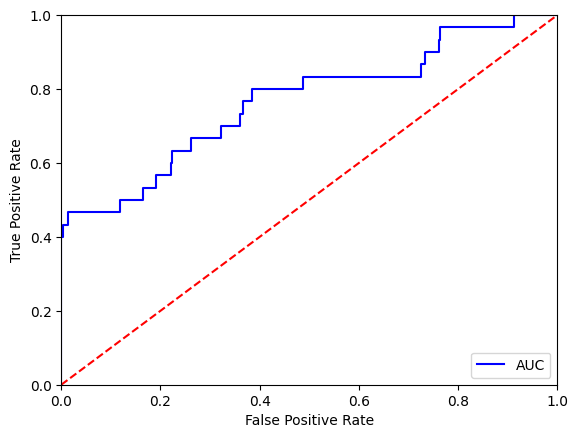

Accuracy for MTDNN on Morgan Fingerprint: 0.9463087248322147
F1 for MTDNN on Morgan Fingerprint: 0.3043478260869565
 True Positive: 0.20588235294117646
 True Negative: 0.9911032028469751
False Positive: 0.008896797153024912
False Negative: 0.7941176470588235
Test ROC AUC (NR-Aromatase): 0.8906740632195939


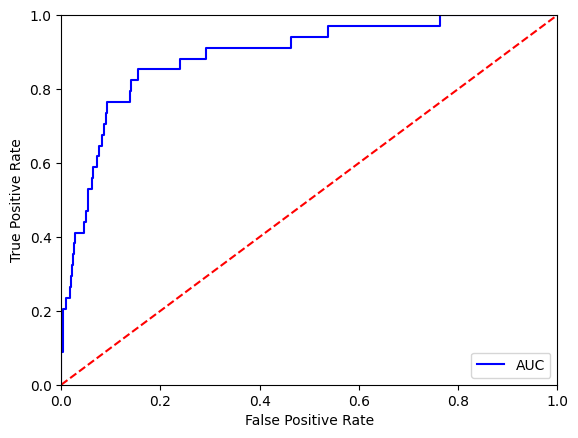

Accuracy for MTDNN on Morgan Fingerprint: 0.9806835066864784
F1 for MTDNN on Morgan Fingerprint: 0.13333333333333333
 True Positive: 0.07142857142857142
 True Negative: 1.0
False Positive: 0.0
False Negative: 0.9285714285714286
Test ROC AUC (NR-PPAR-gamma): 0.6089312811619335


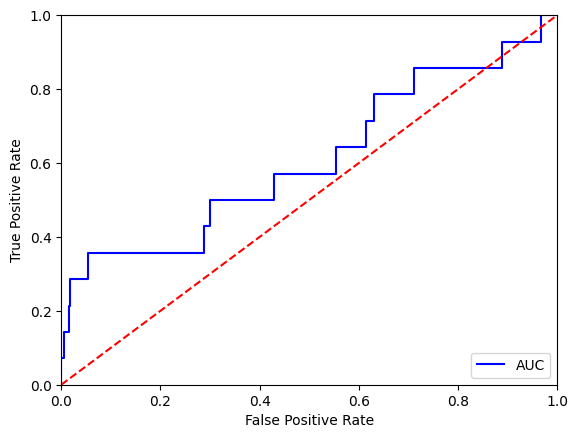

Accuracy for MTDNN on Morgan Fingerprint: 0.9511111111111111
F1 for MTDNN on Morgan Fingerprint: 0.35294117647058826
 True Positive: 0.25
 True Negative: 0.9906103286384976
False Positive: 0.009389671361502348
False Negative: 0.75
Test ROC AUC (SR-HSE): 0.8386802295253


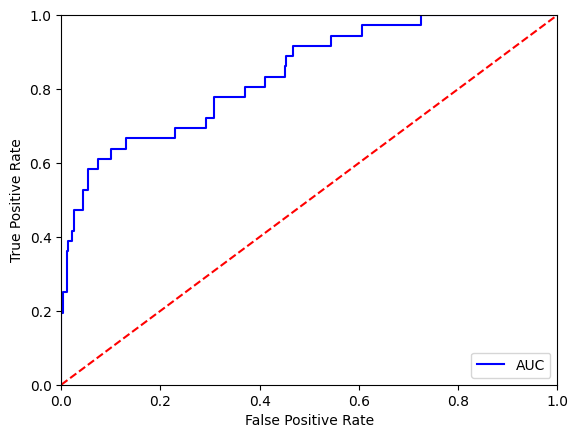

Accuracy for MTDNN on Morgan Fingerprint: 0.9900990099009901
F1 for MTDNN on Morgan Fingerprint: 0.7741935483870968
 True Positive: 0.7058823529411765
 True Negative: 0.9971014492753624
False Positive: 0.002898550724637681
False Negative: 0.29411764705882354
Test ROC AUC (NR-AR-LBD): 0.8549872122762148


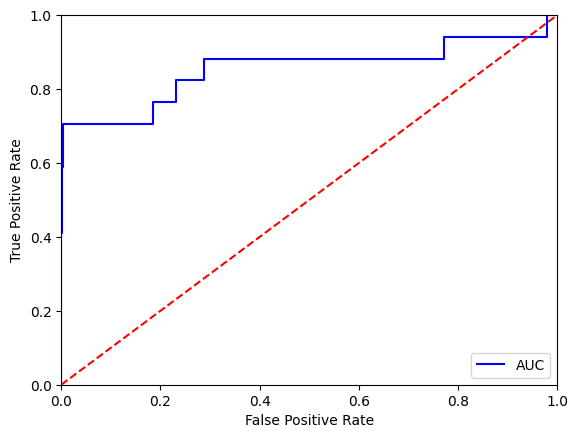

Accuracy for MTDNN on Morgan Fingerprint: 0.885145482388974
F1 for MTDNN on Morgan Fingerprint: 0.4274809160305343
 True Positive: 0.28865979381443296
 True Negative: 0.9892086330935251
False Positive: 0.01079136690647482
False Negative: 0.711340206185567
Test ROC AUC (NR-ER): 0.7329414818660536


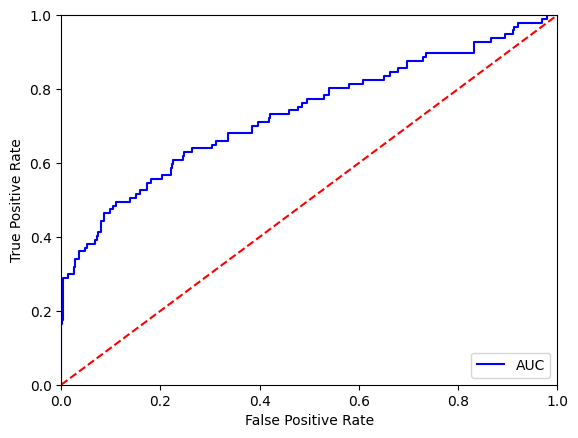

Accuracy for MTDNN on Morgan Fingerprint: 0.8486394557823129
F1 for MTDNN on Morgan Fingerprint: 0.4258064516129032
 True Positive: 0.34375
 True Negative: 0.9471544715447154
False Positive: 0.052845528455284556
False Negative: 0.65625
Test ROC AUC (SR-ARE): 0.8130504742547426


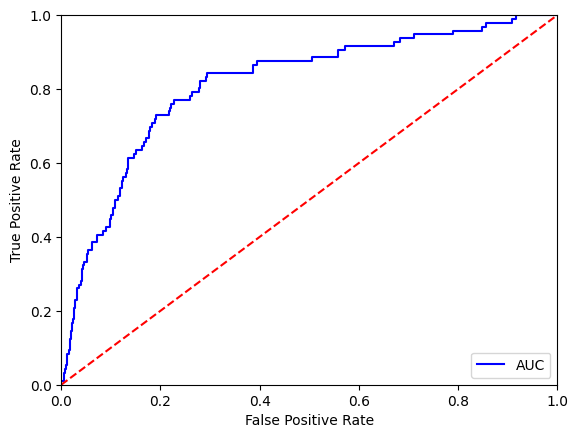

Accuracy for MTDNN on Morgan Fingerprint: 0.8984771573604061
F1 for MTDNN on Morgan Fingerprint: 0.6629213483146067
 True Positive: 0.6210526315789474
 True Negative: 0.9516129032258065
False Positive: 0.04838709677419355
False Negative: 0.37894736842105264
Test ROC AUC (SR-MMP): 0.8927631578947368


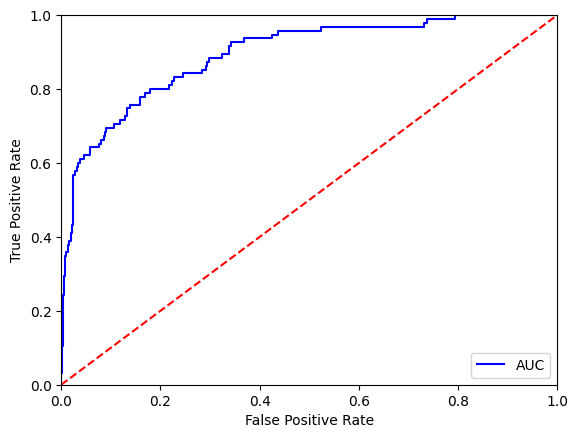

Accuracy for MTDNN on Morgan Fingerprint: 0.9202363367799113
F1 for MTDNN on Morgan Fingerprint: 0.5909090909090908
 True Positive: 0.4875
 True Negative: 0.9782244556113903
False Positive: 0.021775544388609715
False Negative: 0.5125
Test ROC AUC (NR-AhR): 0.9202470686767169


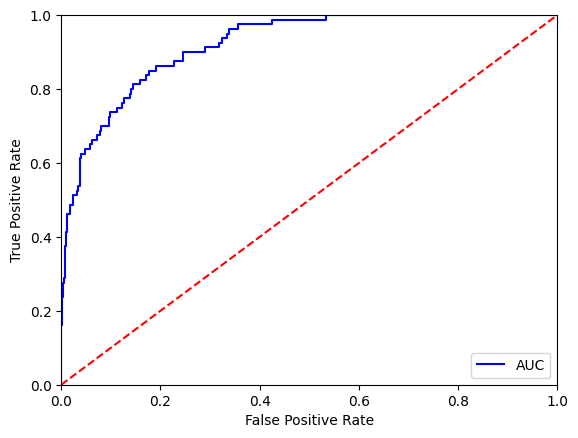

Accuracy for MTDNN on Morgan Fingerprint: 0.9557399723374828
F1 for MTDNN on Morgan Fingerprint: 0.5428571428571428
 True Positive: 0.4318181818181818
 True Negative: 0.9896907216494846
False Positive: 0.010309278350515464
False Negative: 0.5681818181818182
Test ROC AUC (NR-ER-LBD): 0.8935935198821796


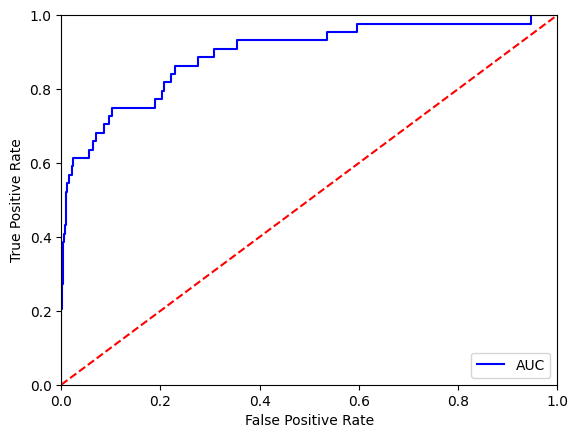

Accuracy for MTDNN on Morgan Fingerprint: 0.9715447154471545
F1 for MTDNN on Morgan Fingerprint: 0.27586206896551724
 True Positive: 0.16666666666666666
 True Negative: 0.9985994397759104
False Positive: 0.0014005602240896359
False Negative: 0.8333333333333334
Test ROC AUC (SR-ATAD5): 0.804796918767507


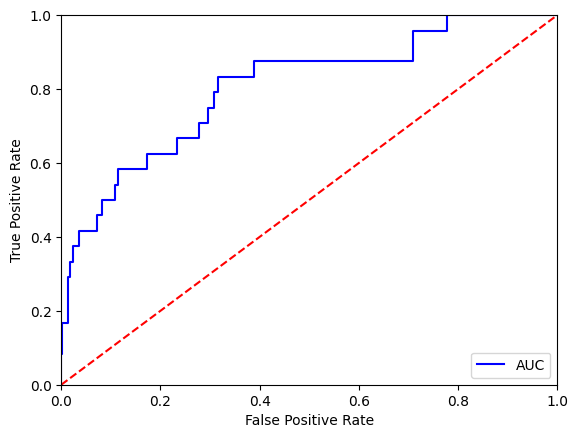

Accuracy for MTDNN on Morgan Fingerprint: 0.935064935064935
F1 for MTDNN on Morgan Fingerprint: 0.1509433962264151
 True Positive: 0.08888888888888889
 True Negative: 0.9938271604938271
False Positive: 0.006172839506172839
False Negative: 0.9111111111111111
Test ROC AUC (SR-p53): 0.8410493827160495


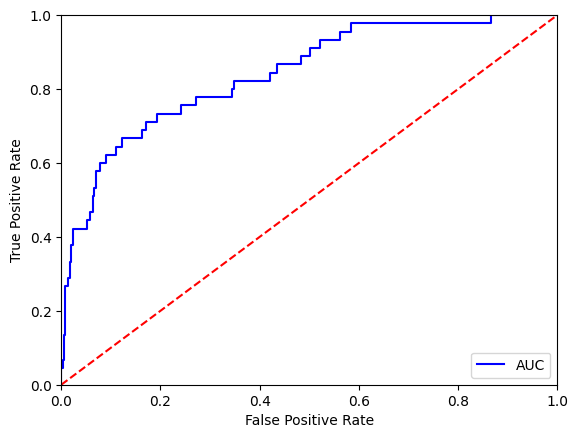

In [354]:
results = {}
# Collects performance metrics for all tasks on test set
for i in range(len(all_tasks)):
    
    valid_datapoints = y_test[:,i] >= 0
    y_test_task = y_test[valid_datapoints,i] 
    y_test_pred_task = y_test_pred[i].detach().numpy()[valid_datapoints,0]
    
    acc = accuracy_score(y_test_task, np.round(y_test_pred_task))
    print('Accuracy for MTDNN on Morgan Fingerprint:', acc)
    
    bacc = sk.metrics.balanced_accuracy_score(y_test_task, np.round(y_test_pred_task))

    f1 = f1_score(y_test_task, np.round(y_test_pred_task), pos_label=1)
    print('F1 for MTDNN on Morgan Fingerprint:', f1)

    cfm = sk.metrics.confusion_matrix(y_test_task, np.round(y_test_pred_task))
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]

    tn, fp, fn, tp = cfm.ravel()
    pr = tp / (tp + fp)
    rc = tp / (tp + fn)
    print(' True Positive:', tp)
    print(' True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    
    auc = roc_auc_score(y_test_task, y_test_pred_task)
    print('Test ROC AUC ({}):'.format(all_tasks[i]), auc)
    
    results[all_tasks[i]] = [auc, acc, bacc, tn, tp, pr, rc, f1]

    fpr, tpr, threshold = sk.metrics.roc_curve(y_test_task, y_test_pred_task)
    plt.plot(fpr, tpr, 'b', label = 'AUC')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [355]:
print('Task'.ljust(10), '\t', '  AUC ', ' ACC ', ' BACC ', ' TN  ', ' TP  ', ' PR  ', ' RC  ', ' F1  ')
for task, auc in results.items():
    print(task.ljust(10), '\t', np.round(auc,3))

Task       	   AUC   ACC   BACC   TN    TP    PR    RC    F1  
NR-AR      	 [0.766 0.973 0.699 0.997 0.4   0.993 0.4   0.545]
NR-Aromatase 	 [0.891 0.946 0.598 0.991 0.206 0.959 0.206 0.304]
NR-PPAR-gamma 	 [0.609 0.981 0.536 1.    0.071 1.    0.071 0.133]
SR-HSE     	 [0.839 0.951 0.62  0.991 0.25  0.964 0.25  0.353]
NR-AR-LBD  	 [0.855 0.99  0.851 0.997 0.706 0.996 0.706 0.774]
NR-ER      	 [0.733 0.885 0.639 0.989 0.289 0.964 0.289 0.427]
SR-ARE     	 [0.813 0.849 0.645 0.947 0.344 0.867 0.344 0.426]
SR-MMP     	 [0.893 0.898 0.786 0.952 0.621 0.928 0.621 0.663]
NR-AhR     	 [0.92  0.92  0.733 0.978 0.488 0.957 0.488 0.591]
NR-ER-LBD  	 [0.894 0.956 0.711 0.99  0.432 0.977 0.432 0.543]
SR-ATAD5   	 [0.805 0.972 0.583 0.999 0.167 0.992 0.167 0.276]
SR-p53     	 [0.841 0.935 0.541 0.994 0.089 0.935 0.089 0.151]


##### See Valid set performance

In [356]:
# print test loss
for x_valid_torch, y_valid_torch in valid_generator:
    y_valid_pred = model.eval().to(device).cpu()(x_valid_torch)
    
    # Compute loss over all tasks
    loss = 0
    for i in range(len(all_tasks)):
        y_test_task = y_valid_torch[:,i]
        y_pred_task  = y_valid_pred[i][:,0]

        # compute loss for labels that are not NA
        indice_valid = y_test_task >= 0
        loss_task = criterion(y_pred_task[indice_valid], y_test_task[indice_valid]) / N_test[i]

        loss += loss_task
    
print(loss.item())

0.003687528893351555


Accuracy for deepnn on Morgan Fingerprint: 0.9702702702702702
F1 for deepnn on Morgan Fingerprint: 0.6071428571428571
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.99291785 0.00708215]
 [0.5        0.5       ]]
 True Positive: 0.5
 True Negative: 0.9929178470254958
False Positive: 0.007082152974504249
False Negative: 0.5
Test ROC AUC (NR-AR): 0.8114480919846692


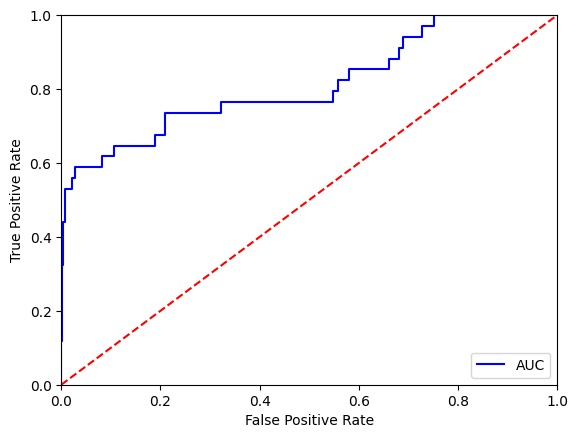

Accuracy for deepnn on Morgan Fingerprint: 0.9478114478114478
F1 for deepnn on Morgan Fingerprint: 0.20512820512820512
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.99466192 0.00533808]
 [0.875      0.125     ]]
 True Positive: 0.125
 True Negative: 0.994661921708185
False Positive: 0.005338078291814947
False Negative: 0.875
Test ROC AUC (NR-Aromatase): 0.8095529359430605


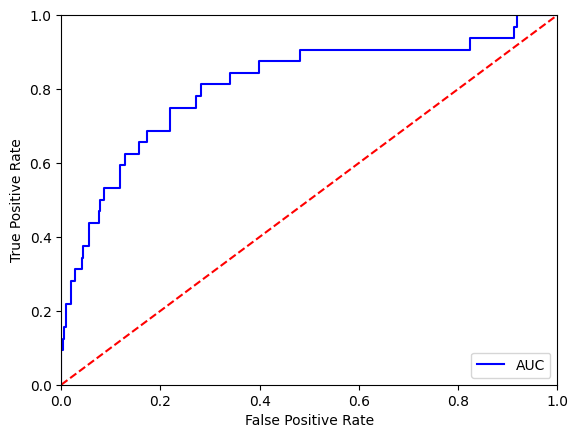

Accuracy for deepnn on Morgan Fingerprint: 0.971342383107089
F1 for deepnn on Morgan Fingerprint: 0.23999999999999996
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.99534161 0.00465839]
 [0.84210526 0.15789474]]
 True Positive: 0.15789473684210525
 True Negative: 0.9953416149068323
False Positive: 0.004658385093167702
False Negative: 0.8421052631578947
Test ROC AUC (NR-PPAR-gamma): 0.8784733573063092


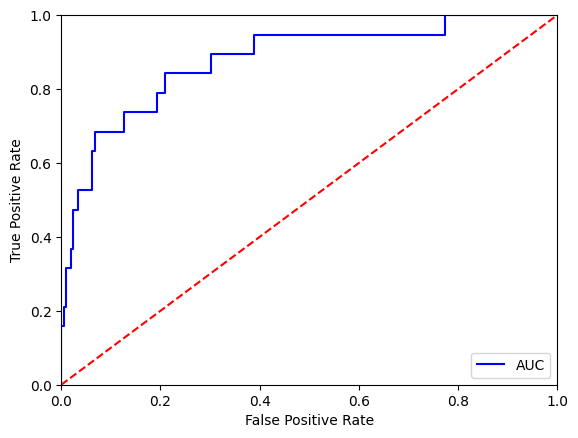

Accuracy for deepnn on Morgan Fingerprint: 0.93993993993994
F1 for deepnn on Morgan Fingerprint: 0.28571428571428575
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.98722045 0.01277955]
 [0.8        0.2       ]]
 True Positive: 0.2
 True Negative: 0.987220447284345
False Positive: 0.012779552715654952
False Negative: 0.8
Test ROC AUC (SR-HSE): 0.7382587859424922


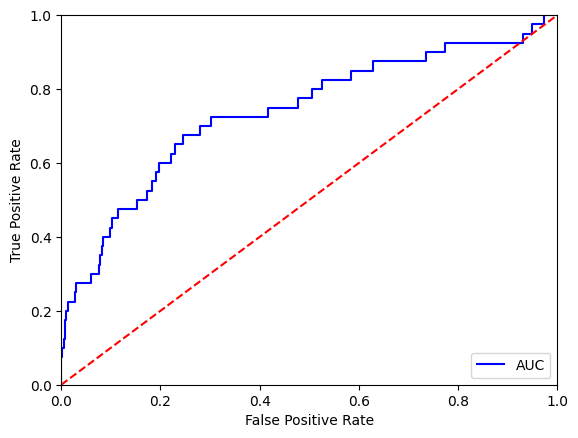

Accuracy for deepnn on Morgan Fingerprint: 0.9694767441860465
F1 for deepnn on Morgan Fingerprint: 0.5531914893617021
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.98791541 0.01208459]
 [0.5        0.5       ]]
 True Positive: 0.5
 True Negative: 0.9879154078549849
False Positive: 0.012084592145015106
False Negative: 0.5
Test ROC AUC (NR-AR-LBD): 0.8287241459446897


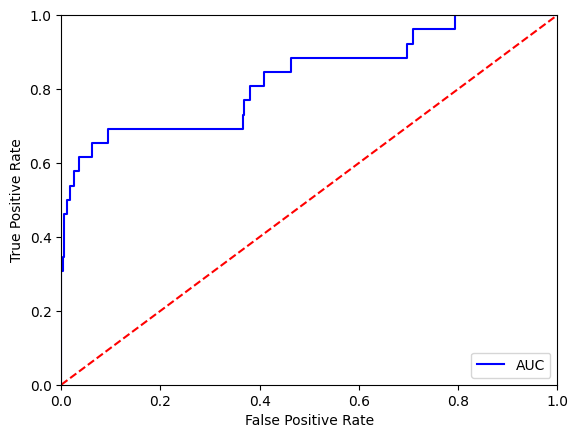

Accuracy for deepnn on Morgan Fingerprint: 0.8865814696485623
F1 for deepnn on Morgan Fingerprint: 0.4409448818897638
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.97053407 0.02946593]
 [0.6626506  0.3373494 ]]
 True Positive: 0.3373493975903614
 True Negative: 0.9705340699815838
False Positive: 0.029465930018416207
False Negative: 0.6626506024096386
Test ROC AUC (NR-ER): 0.7666577913865407


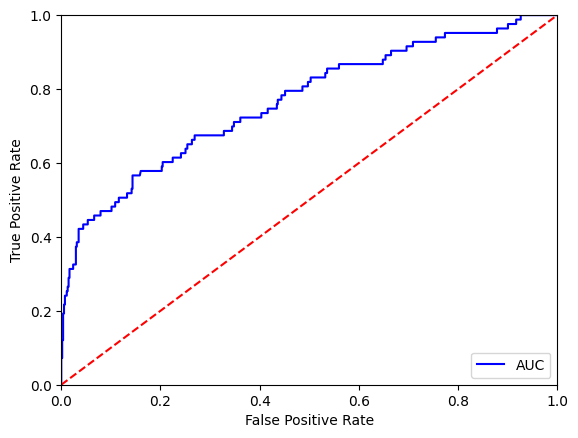

Accuracy for deepnn on Morgan Fingerprint: 0.8311036789297659
F1 for deepnn on Morgan Fingerprint: 0.34838709677419355
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.94188377 0.05811623]
 [0.72727273 0.27272727]]
 True Positive: 0.2727272727272727
 True Negative: 0.9418837675350702
False Positive: 0.05811623246492986
False Negative: 0.7272727272727273
Test ROC AUC (SR-ARE): 0.7907329811137427


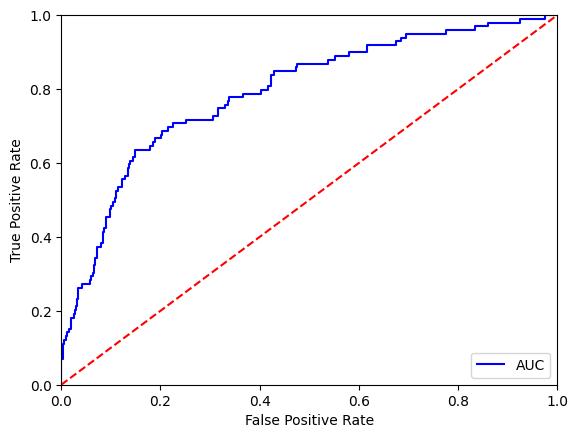

Accuracy for deepnn on Morgan Fingerprint: 0.883248730964467
F1 for deepnn on Morgan Fingerprint: 0.6101694915254238
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.93975904 0.06024096]
 [0.41935484 0.58064516]]
 True Positive: 0.5806451612903226
 True Negative: 0.9397590361445783
False Positive: 0.060240963855421686
False Negative: 0.41935483870967744
Test ROC AUC (SR-MMP): 0.8948913935311137


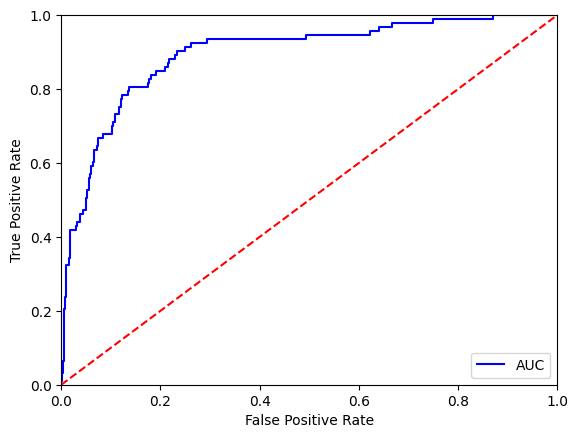

Accuracy for deepnn on Morgan Fingerprint: 0.9227340267459139
F1 for deepnn on Morgan Fingerprint: 0.559322033898305
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.97836938 0.02163062]
 [0.54166667 0.45833333]]
 True Positive: 0.4583333333333333
 True Negative: 0.978369384359401
False Positive: 0.021630615640599003
False Negative: 0.5416666666666666
Test ROC AUC (NR-AhR): 0.9019458310223701


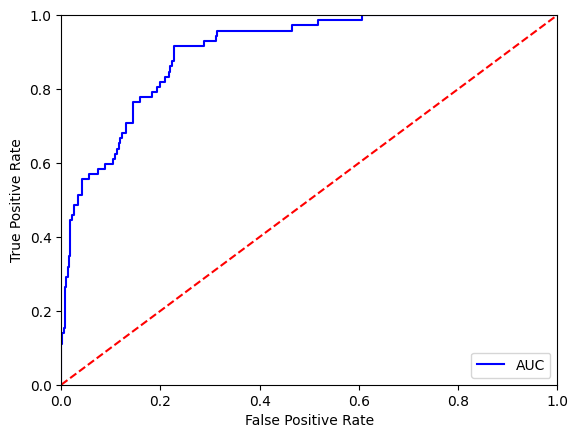

Accuracy for deepnn on Morgan Fingerprint: 0.9572649572649573
F1 for deepnn on Morgan Fingerprint: 0.5588235294117647
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.98789713 0.01210287]
 [0.53658537 0.46341463]]
 True Positive: 0.4634146341463415
 True Negative: 0.9878971255673222
False Positive: 0.012102874432677761
False Negative: 0.5365853658536586
Test ROC AUC (NR-ER-LBD): 0.7954319028818124


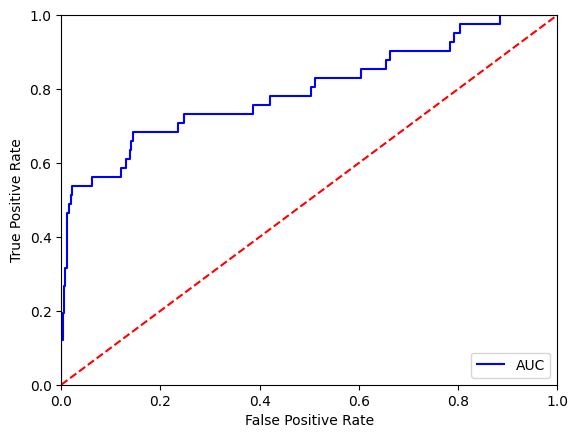

Accuracy for deepnn on Morgan Fingerprint: 0.9679218967921897
F1 for deepnn on Morgan Fingerprint: 0.08
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.9971223  0.0028777 ]
 [0.95454545 0.04545455]]
 True Positive: 0.045454545454545456
 True Negative: 0.9971223021582734
False Positive: 0.0028776978417266188
False Negative: 0.9545454545454546
Test ROC AUC (SR-ATAD5): 0.7302812295618052


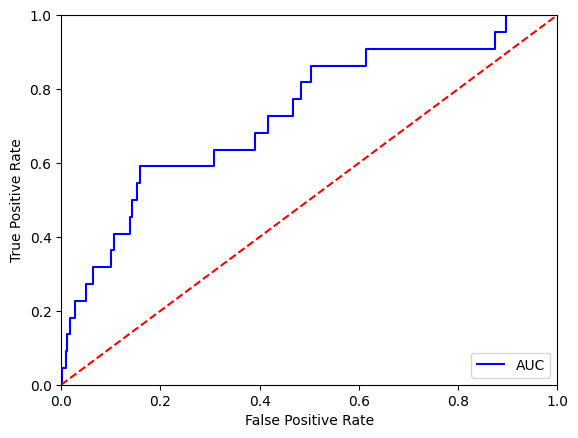

Accuracy for deepnn on Morgan Fingerprint: 0.9471428571428572
F1 for deepnn on Morgan Fingerprint: 0.3272727272727273
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.99090909 0.00909091]
 [0.775      0.225     ]]
 True Positive: 0.225
 True Negative: 0.990909090909091
False Positive: 0.00909090909090909
False Negative: 0.775
Test ROC AUC (SR-p53): 0.8351136363636363


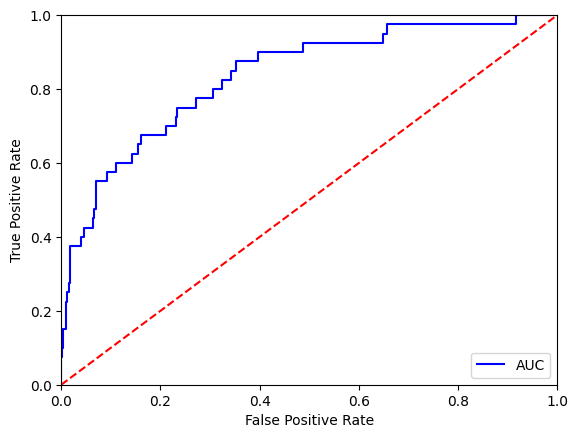

In [357]:
results_valid = {}
# Collects performance metrics for all tasks on Valid set
for i in range(len(all_tasks)):
    
    valid_datapoints = y_valid[:,i] >= 0
    y_valid_task = y_valid[valid_datapoints,i] 
    y_valid_pred_task = y_valid_pred[i].detach().numpy()[valid_datapoints,0]
    
    
    acc = accuracy_score(y_valid_task, np.round(y_valid_pred_task))
    print('Accuracy for deepnn on Morgan Fingerprint:', acc)
    
    bacc = sk.metrics.balanced_accuracy_score(y_valid_task, np.round(y_valid_pred_task))

    f1 = f1_score(y_valid_task, np.round(y_valid_pred_task), pos_label=1)
    print('F1 for deepnn on Morgan Fingerprint:', f1)

    cfm = sk.metrics.confusion_matrix(y_valid_task, np.round(y_valid_pred_task))
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]

    print('Confusion Matrix for deepnn on Morgan Fingerprint:\n', cfm)

    tn, fp, fn, tp = cfm.ravel()
    pr = tp / (tp + fp)
    rc = tp / (tp + fn)
    print(' True Positive:', tp)
    print(' True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    
    auc = roc_auc_score(y_valid_task, y_valid_pred_task)
    print('Test ROC AUC ({}):'.format(all_tasks[i]), auc)
    
    results_valid[all_tasks[i]] = [auc, acc, bacc, tn, tp, pr, rc, f1]

    fpr, tpr, threshold = sk.metrics.roc_curve(y_valid_task, y_valid_pred_task)
    plt.plot(fpr, tpr, 'b', label = 'AUC')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [358]:
print('Task'.ljust(10), '\t', '  AUC ', ' ACC ', ' BACC ', ' TN  ', ' TP  ', ' PR  ', ' RC  ', ' F1  ')
for task, auc in results_valid.items():
    print(task.ljust(10), '\t', np.round(auc,3))

Task       	   AUC   ACC   BACC   TN    TP    PR    RC    F1  
NR-AR      	 [0.811 0.97  0.746 0.993 0.5   0.986 0.5   0.607]
NR-Aromatase 	 [0.81  0.948 0.56  0.995 0.125 0.959 0.125 0.205]
NR-PPAR-gamma 	 [0.878 0.971 0.577 0.995 0.158 0.971 0.158 0.24 ]
SR-HSE     	 [0.738 0.94  0.594 0.987 0.2   0.94  0.2   0.286]
NR-AR-LBD  	 [0.829 0.969 0.744 0.988 0.5   0.976 0.5   0.553]
NR-ER      	 [0.767 0.887 0.654 0.971 0.337 0.92  0.337 0.441]
SR-ARE     	 [0.791 0.831 0.607 0.942 0.273 0.824 0.273 0.348]
SR-MMP     	 [0.895 0.883 0.76  0.94  0.581 0.906 0.581 0.61 ]
NR-AhR     	 [0.902 0.923 0.718 0.978 0.458 0.955 0.458 0.559]
NR-ER-LBD  	 [0.795 0.957 0.726 0.988 0.463 0.975 0.463 0.559]
SR-ATAD5   	 [0.73  0.968 0.521 0.997 0.045 0.94  0.045 0.08 ]
SR-p53     	 [0.835 0.947 0.608 0.991 0.225 0.961 0.225 0.327]
